In [1]:
%matplotlib inline
from bs4 import BeautifulSoup
import pandas as pd
import dateparser
import missingno as msno
import re
import operator
import itertools
from string import capwords # trim, titlecase https://docs.python.org/3/library/string.html#string.capwords

In [2]:
cols = ['source','year','name','dob','desc']

# 2018 list

In [3]:
def clean_name(string):
    return capwords(string.replace('.','')).title()

In [4]:
# Extract from http://putin2018.ru/trusted/ html:
def extract_from_html(e):
    name = clean_name(e.select('a')[0].extract().text)
    desc = e.text.strip()
    return ("putin2018", None, name, None, desc)

with open("data/raw/putin2018_trusted.html") as f:
    soup = BeautifulSoup(f.read(), "lxml")
    entries = soup.select('li.person-by-alphabet-list_item')
    df_2018_putinru = pd.DataFrame([extract_from_html(e) for e in entries], columns=cols)
    df_2018_putinru['year'] = '2018'

print("putin2018.ru", len(df_2018_putinru))
df_2018_putinru.sample(5)

putin2018.ru 487


,source,year,name,dob,desc
402,putin2018,2018,Стриханов Михаил Николаевич,None,Ректор МИФИ
14,putin2018,2018,Андреев Александр Вадимович,None,Генеральный директор ОАО «Международный аэропо...
466,putin2018,2018,Шишкина Алла Анатольевна,None,"Спортсмен СШОР по синхронному плаванию ГБУ ""МГ..."
326,putin2018,2018,Перфилова Валерия Юрьевна,None,"Российская эстрадная певица (Валерия), Народна..."
219,putin2018,2018,Крутой Игорь Яковлевич,None,Композитор


# 2018 list from cikrf

In [5]:
def cikrf_df(files, func):
    df = pd.DataFrame(columns=cols)
    for file in files:
        with open('data/raw/'+file) as f:
            text = f.read()
            text = text.replace('№ ', '№') # Make splitting easier
            #text = text.replace('–', '—') # ndash with mdash
            list_ = re.compile('\s\d+\.').split(text)
            list_ = list_[1:] # skip header

            df_ = pd.DataFrame([func(e) for e in list_], columns=cols)        
            df_['source'] = file.replace('.txt','')

            df = df.append(df_, ignore_index=True)
            print(file, '+', len(df_), '\t', len(df))

    return df

In [6]:
def extract_2018_txt(el):
    name = clean_name(el)
    return (None, '2018', name, None, None)

In [7]:
files2018 = ['126-1057-7.txt','131-1085-7.txt','134-1108-7.txt','144-1192-7.txt']
df_2018_cikrf = cikrf_df(files2018, extract_2018_txt)
df_2018_cikrf.sample(5)

126-1057-7.txt + 259 	 259
131-1085-7.txt + 154 	 413
134-1108-7.txt + 62 	 475
144-1192-7.txt + 16 	 491


,source,year,name,dob,desc
208,126-1057-7,2018,Симоньян Маргарита Симоновна,None,None
410,131-1085-7,2018,Эйфман Борис Яковлевич,None,None
236,126-1057-7,2018,Халиков Тимур Рафаэлевич,None,None
267,131-1085-7,2018,Бакулина Марина Олеговна,None,None
450,134-1108-7,2018,Петреня Юрий Кирилович,None,None


# 2012 list

In [8]:
def extract_2012_txt(el):
    e = el.strip().replace('\n',' ').replace('\t',' ').replace('  ',' ')
    elements = e.replace(', дата рождения','').replace(' года, основное место работы ','').split('\uf02d')
    name = clean_name(elements[0])
    dob = dateparser.parse(elements[1])
    desc = elements[2].strip()
    return (None, '2012', name, dob, desc)

In [9]:
# manually "cleaned"
files2012 = ['96-767-6.txt','98-785-6.txt','100-798-6.txt','107-858-6.txt']
df_2012_cikrf = cikrf_df(files2012, extract_2012_txt)
df_2012_cikrf.sample(5)

96-767-6.txt + 499 	 499
98-785-6.txt + 4 	 503
100-798-6.txt + 17 	 520
107-858-6.txt + 8 	 528


,source,year,name,dob,desc
13,96-767-6,2012,Антимонова Марина Юрьевна,1966-06-14,муниципальное медицинское бюджетное учреждение...
382,96-767-6,2012,Садыков Союн Касумович,1960-03-05,"ООО СК ""Мосреконструкция"", генеральный директор."
345,96-767-6,2012,Першилин Константин Георгиевич,1934-01-01,"открытое акционерное общество племзавод ""Учхоз..."
218,96-767-6,2012,Корнеева Надежда Анатольевна,1958-09-19,"Политическая партия ""ПАТРИОТЫ РОССИИ"", председ..."
390,96-767-6,2012,Селиверстов Николай Иванович,1947-04-26,федеральное государственное бюджетное учрежден...


In [10]:
cols_extended = ["source","name","dob","desc", # gathered
                 "wikidata","email","vk","ig","fb","tw","yt","ok","zampolit","sanctioned" # possible?
                ]

df_2012_cikrf.to_csv('data/csv/2012_cikrf.csv', index=False, columns=cols_extended)
df_2018_cikrf.to_csv('data/csv/2018_cikrf.csv', index=False, columns=cols_extended)
df_2018_putinru.to_csv('data/csv/2018_putinru.csv', index=False, columns=cols_extended)

/home/igor/anaconda3/lib/python3.6/site-packages/pandas/io/formats/format.py:1586: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  self.obj = self.obj.loc[:, cols]
/home/igor/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [11]:
# Names only:
df_2012_cikrf.sort_values(by=['name'])['name'].to_csv('data/names/2012_cikrf_names.txt', index=False, header=False)
df_2018_cikrf.sort_values(by=['name'])['name'].to_csv('data/names/2018_cikrf_names.txt', index=False, header=False)
df_2018_putinru.sort_values(by=['name'])['name'].to_csv('data/names/2018_putinru_names.txt', index=False, header=False)

# Merge Names

In [20]:
df_merge = pd.concat([df_2012_cikrf, df_2018_cikrf, df_2018_putinru], ignore_index=True)

dupes = df_merge[df_merge.duplicated(['name'], keep=False)].sort_values(by=['name'])
print(len(dupes))
dupes.head(10)

1036


,source,year,name,dob,desc
787,131-1085-7,2018,Абисов Юрий Николаевич,NaT,None
1019,putin2018,2018,Абисов Юрий Николаевич,NaT,Помощник Главы Республики Крым по связям с пра...
788,131-1085-7,2018,Авербух Илья Изяславич,NaT,None
1020,putin2018,2018,Авербух Илья Изяславич,NaT,Российский фигурист. Заслуженный мастер спорта...
1021,putin2018,2018,Аветисов Алексей Сергеевич,NaT,"ФГБОУ ""Московский технологический университет""..."
528,126-1057-7,2018,Аветисов Алексей Сергеевич,NaT,None
529,126-1057-7,2018,Агафонова Любовь Викторовна,NaT,None
1022,putin2018,2018,Агафонова Любовь Викторовна,NaT,"Государственное учреждение здравоохранения ""Ли..."
1023,putin2018,2018,Айдуллин Иван Ухливанович,NaT,Мастер по капитальному ремонту скважин ОАО «Су...
941,134-1108-7,2018,Айдуллин Иван Ухливанович,NaT,None


In [23]:
# Some manual replacements for known dupes:
replacements = {
    'Лагутинская Софья Владимировна': 'Лагутинская София Владимировна',
    'Ласицкене Мария Александровна': 'Ласицкене (Кучина) Мария Александровна',
    'Юнусов Тимур Ильдарович': 'Юнусов Тимур Ильдарович (Тимати)',
    'Якубов Февзи': 'Якубов Февзи Якубович',
    'Симонов Юрий Павлович': 'Симонов (Вяземский) Юрий Павлович',
    'Ооржак Ошку-Саар Аракчеевна': 'Ооржак Ошку-Саар Аракчааевна',
    'Назейкин Анатолии Георгиевич': 'Назейкин Анатолий Георгиевич',
    'Львова-Белова Мария Александровна': 'Львова-Белова Мария Алексеевна',
    'Гыштемулте Ефросиниа Николаевна': 'Гыштемулте Ефросиния Николаевна',
    'Вележова Лидия Леонидовна': 'Вележева Лидия Леонидовна'
}

df_merge['name'].replace(replacements, inplace=True)

In [24]:
# can also be sorted(set()) but this works for unhashable types too
def sort_uniq(sequence):
    return map(operator.itemgetter(0), itertools.groupby(sorted(sequence)))

def str_notblank(val):
    return capwords(str(val)) != ''

# Sort, unique, merge values, return list, or none, or single value
def list_agg(vals):
    #list_ = sorted(set([v for v in vals if pd.notnull(v) and pd.notna(v) and str_notblank(v)]))
    list_ = list(sort_uniq([v for v in vals if pd.notnull(v) and pd.notna(v) and str_notblank(v)]))
    if len(list_) == 0:
        return None
    #print(len(list_), list_)
    if len(list_) == 1:
        return list_[0]
    return list_

In [25]:
dedupe_merge = df_merge.groupby(['name']).agg(lambda x: tuple(x)).applymap(list_agg).reset_index()
print(len(dedupe_merge))
dedupe_merge.sample(10)

931


,name,source,year,dob,desc
646,Плющенко Евгений Викторович,"[131-1085-7, 96-767-6, putin2018]","[2012, 2018]",1982-11-03,"[Олимпийский чемпион по фигурному катанию., Фе..."
85,Беляев Николай Александрович,"[126-1057-7, putin2018]",2018,NaT,"ГКОУ г. Москвы, КШИ №1 ""Первый Московский каде..."
575,Невзоров Александр Глебович,96-767-6,2012,1958-08-03,"ОАО ""Первый канал"", режиссер, советник генерал..."
841,Хазанов Геннадий Викторович,96-767-6,2012,1945-12-01,"Московский художественный театр эстрады, худож..."
238,Данилов Константин Иванович,"[131-1085-7, putin2018]",2018,NaT,Руководитель представительства ГК «Ростех» в Т...
928,Ястрикова Ольга Алексеевна,96-767-6,2012,1959-05-06,муниципальное бюджетное общеобразовательное уч...
117,Бугаев Сергей Анатольевич,96-767-6,2012,1966-03-28,"Институт Нового Человека, председатель правления."
492,Макаров Сергей Афанасьевич,"[131-1085-7, putin2018]",2018,NaT,"Генерал-полковник, кавалер Ордена Святого Геор..."
676,Пугин Николай Андреевич,"[131-1085-7, putin2018]",2018,NaT,"Президент ОАО «ГАЗ», член Общественной палаты ..."
591,Носкова Ольга Юрьевна,96-767-6,2012,1982-07-09,"КОГБУЗ ""Кировская детская городская клиническа..."


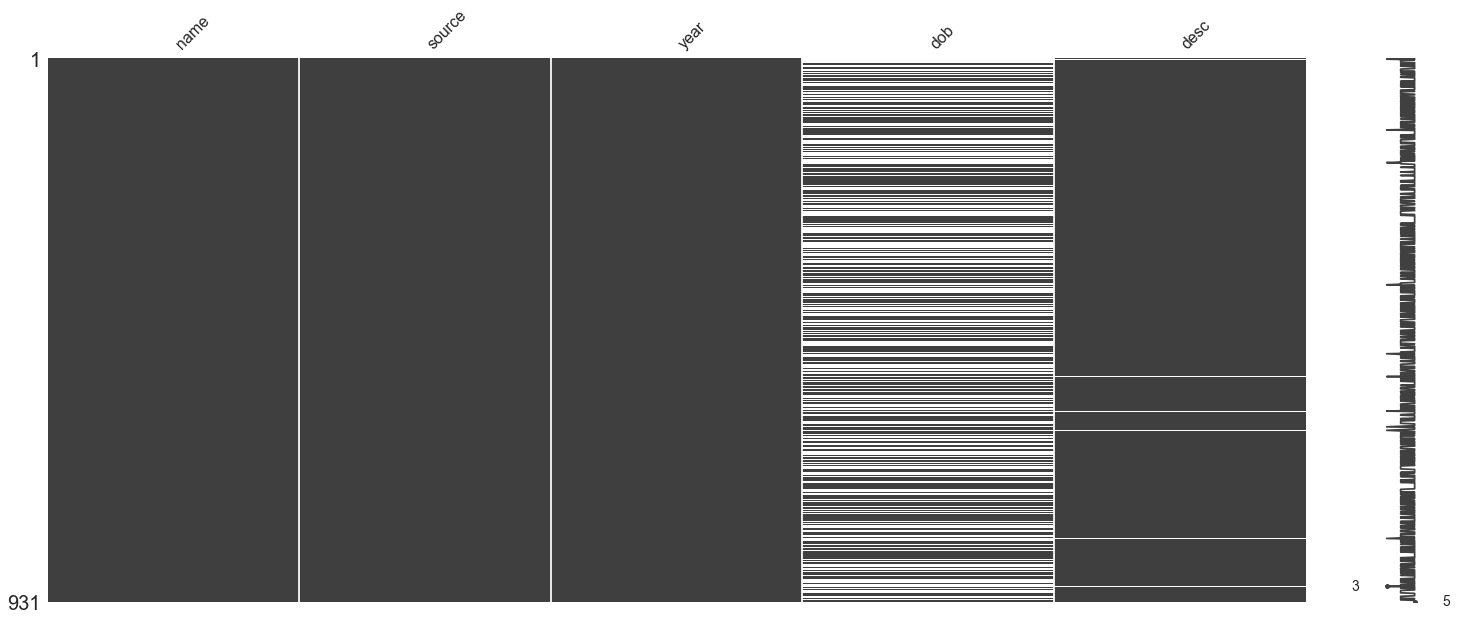

In [26]:
# Missing Values
msno.matrix(dedupe_merge)

In [27]:
dedupe_merge.sort_values(by=['name'])['name'].to_csv('data/names/merged_names.txt', index=False, header=False)

In [29]:
dedupe_merge[pd.isna(dedupe_merge['desc'])]

,name,source,year,dob,desc
2,Абросимов Роман Владимирович,144-1192-7,2018,NaT,None
123,Бурт Анастасия Андреевна,134-1108-7,2018,NaT,None
179,Галустян Ншан Сергеевич,131-1085-7,2018,NaT,None
388,Кондрашов Андрей Олегович,126-1057-7,2018,NaT,None
506,Манучаров Вячеслав Рафаэлевич,131-1085-7,2018,NaT,None
545,Михалков Андрей Сергеевич,131-1085-7,2018,NaT,None
604,Омельченко Святослав Дмитриевич,126-1057-7,2018,NaT,None
631,Петреня Юрий Кирилович,134-1108-7,2018,NaT,None
637,Петросянц Евгений Ваганович,131-1085-7,2018,NaT,None
822,Устинова Варвара Михайловна,131-1085-7,2018,NaT,None
